# MLND Capstone: Plant Disease Detection 
By: Hesham Abdullah

**-Importing the required packages**

In [1]:
from os import listdir
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from keras.applications.inception_v3 import InceptionV3
from keras.models import load_model
from keras.models import Model
import os
import pandas as pd
import seaborn as sns





Using TensorFlow backend.


**-Setting up the data paths and the variables**

In [3]:
directory_root = 'D:\Mahmoud Nada\Hesham\plantdisease'
data_path='D:\Mahmoud Nada\Hesham\plantdisease\PlantVillage'
width=256
height=256
depth=3
test_path=('D:\Mahmoud Nada\Hesham\test')
path=('../input/plantdisease/PlantVillage')

Listing down the classes in the dataset

In [76]:
listdir(data_path)

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___healthy',
 'Potato___Late_blight',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_healthy',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_mosaic_virus',
 'Tomato__Tomato_YellowLeaf__Curl_Virus']

-Data Preprocessing:


a helper function for converting the image into array and resizing the image.

In [77]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, (112,112))   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Loading the images into training, testing and validation sets

In [78]:
image_list, label_list,val_image_list,val_label_list = [], [],[], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:600]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
            for image in plant_disease_image_list[:100]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    val_image_list.append(convert_image_to_array(image_directory))
                    val_label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")
    
len(image_list)

[INFO] Loading images ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Image loading completed


8622

Label Binarizing the labels

In [79]:
label_bin=LabelBinarizer()
image_labels=label_bin.fit_transform(label_list)
pickle.dump(label_bin,open('label_transform.pkl', 'wb'))
n_classes=len(label_bin.classes_)
print(n_classes,"\n",label_bin.classes_)

15 
 ['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [80]:
val_label_bin=LabelBinarizer()
val_image_labels=val_label_bin.fit_transform(val_label_list)
pickle.dump(val_label_bin,open('val_label_transform.pkl', 'wb'))
n_classes=len(val_label_bin.classes_)
print(n_classes,"\n",val_label_bin.classes_)

15 
 ['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


Data Normalization

In [81]:
norm_image_list=np.array(image_list,dtype=np.float16)/255
val_norm_image_list=np.array(val_image_list,dtype=np.float16)/255

Splitting the data into training and testing sets by 20% ratio

In [82]:
X_train,X_test,y_train,y_test=train_test_split(norm_image_list,image_labels,test_size=0.2,random_state=7)

In [83]:
labels=val_label_bin.classes_

In [84]:
# listdir(data_path)

Plotting the training set distribution 

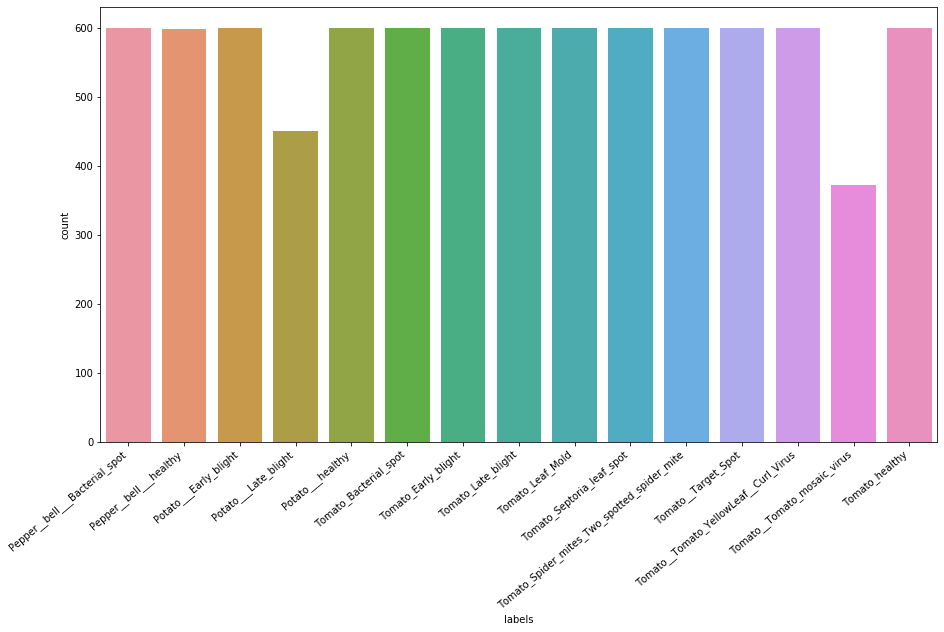

In [85]:
df = pd.DataFrame()
df["labels"]=label_list
lab = df['labels']
dist = lab.value_counts()
# sns.countplot(lab)
plt.figure(figsize=(15,8))
ax=sns.countplot(lab)
ax.set_xticklabels(ax.set_xticklabels(val_label_bin.classes_),rotation=40,ha="right")
# plt.tight_layout()
plt.show()

Plotting the validation set distribution 

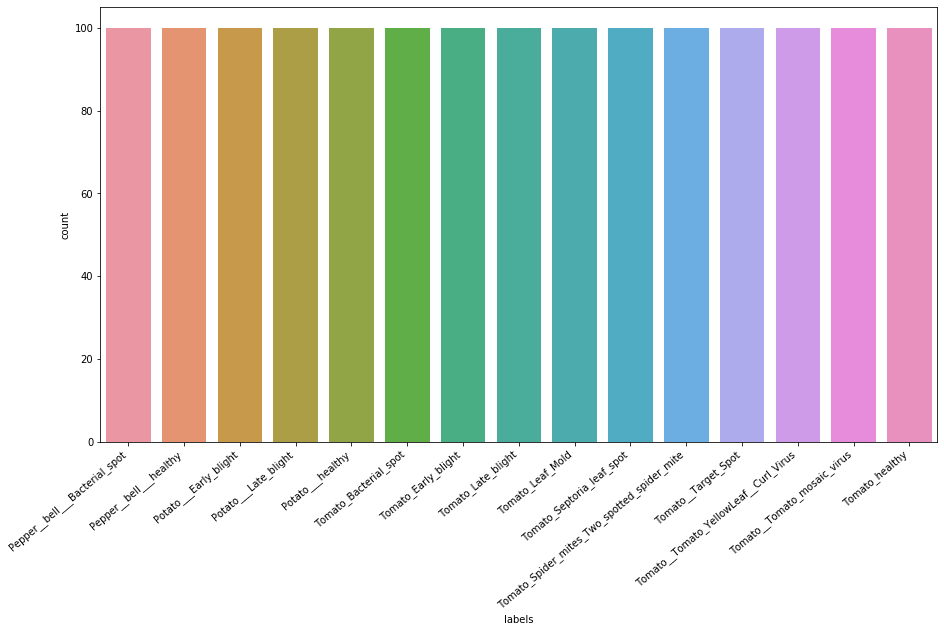

In [13]:
df = pd.DataFrame()
df["labels"]=val_label_list
lab = df['labels']
dist = lab.value_counts()
# sns.countplot(lab)
plt.figure(figsize=(15,8))
ax=sns.countplot(lab)
ax.set_xticklabels(ax.set_xticklabels(val_label_bin.classes_),rotation=40,ha="right")
# plt.tight_layout()
plt.show()

Defining the custom CNN architecture

In [33]:
model = Sequential()
chanDim = -1
model.add(Conv2D(32, (2, 2), padding="same", activation='relu',input_shape=(112,112,3)))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(32, (2, 2), padding="same", activation='relu'))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (2, 2), padding="same",activation='relu'))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (2, 2), padding="same",activation='relu'))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (2, 2), padding="same",activation='relu'))
model.add(BatchNormalization(axis=chanDim))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())
model.add(Dense(n_classes))
model.add(Activation("softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 112, 112, 32)      416       
_________________________________________________________________
batch_normalization_95 (Batc (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 112, 112, 32)      4128      
_________________________________________________________________
batch_normalization_96 (Batc (None, 112, 112, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 56, 56, 64)       

Compiling the model and setting the model's checkpointer

In [34]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
checkpointer= ModelCheckpoint(filepath='../trial_2.hdf5',
                             verbose=1,save_best_only=True)

Training the model

In [37]:
history=model.fit(X_train, y_train, 
          validation_data=(val_norm_image_list, val_image_labels),
          epochs=40, batch_size=32, callbacks=[checkpointer], verbose=1)

Train on 6659 samples, validate on 1500 samples
Epoch 1/40
6659/6659 [==============================] - 9s 1ms/step - loss: 1.2255 - accuracy: 0.6315 - val_loss: 9.5512 - val_accuracy: 0.0667

Epoch 00001: val_loss improved from inf to 9.55115, saving model to ../trial_2.hdf5
Epoch 2/40
6659/6659 [==============================] - 8s 1ms/step - loss: 0.7654 - accuracy: 0.7674 - val_loss: 10.2988 - val_accuracy: 0.0800

Epoch 00002: val_loss did not improve from 9.55115
Epoch 3/40
6659/6659 [==============================] - 8s 1ms/step - loss: 0.6171 - accuracy: 0.8162 - val_loss: 2.9847 - val_accuracy: 0.3047

Epoch 00003: val_loss improved from 9.55115 to 2.98472, saving model to ../trial_2.hdf5
Epoch 4/40
6659/6659 [==============================] - 8s 1ms/step - loss: 0.5230 - accuracy: 0.8369 - val_loss: 0.6238 - val_accuracy: 0.7987

Epoch 00004: val_loss improved from 2.98472 to 0.62382, saving model to ../trial_2.hdf5
Epoch 5/40
6659/6659 [==============================] - 8s 1

Loading the best weights obtained from the checkpointer during the training

In [38]:
model.load_weights('../trial_1.hdf5')


Model evaluation by calculating the accuracy

In [39]:
score=model.evaluate(X_test,y_test,verbose=1)
print("test accuracy:",score)

1665/1665 [==============================] - 1s 524us/step
test accuracy: [0.5663621356252122, 0.8078078031539917]


Plotting: the training accuracy vs the validation accuracy and the training loss vs validation loss
    

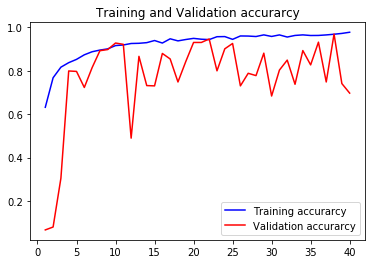

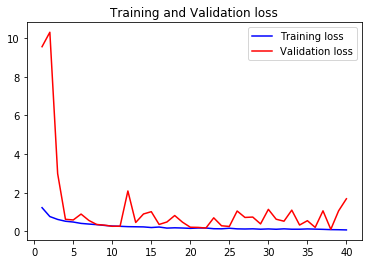

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()


In [ ]:
# model.save("D:\Mahmoud Nada\Hesham\saved_model.h5")

In [ ]:
# loaded_model=load_model('D:\Mahmoud Nada\Hesham\saved_model.h5')
# # loaded_model.load_weights('../trial_1.hdf5')
# loaded_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])


In [ ]:
# score=loaded_model.evaluate(X_test,y_test,verbose=1)
# print("test accuracy:",score)

A helper functions for loading the images used for testing the model performance

In [4]:
def load_test_data():
    images = []
    names = []
    size = 224,224
    for image in os.listdir(test_path):
        temp = cv2.imread(test_path + '/' + image)
        temp = cv2.resize(temp, size)
        images.append(temp)
        names.append(image)
    images = np.array(images)
    images = images.astype('float32')/255.0
    return images, names

In [42]:
def load_broad_test_data():
    images = []
    names = []
    size = 224,224
    
#     for count in range(0,5):    
    for direc in listdir(data_path): 
        count=0
        for image in listdir(f'{data_path}/{direc}'):
            temp = cv2.imread(f'{data_path}/{direc}/{image}')
            temp = cv2.resize(temp, size)
            images.append(temp)
            names.append(image)
            count+=1
            if count < 15:
                break
    images = np.array(images)
    images = images.astype('float32')/255.0
    return images, names

Loading the images

In [43]:
test_images, test_labels = load_test_data()

In [44]:
print(len(test_images))

15


A function that returns the prediction returned by the trained model 

In [55]:
def get_predictions(test_data, model):
    prediction_classes = []
    for image in test_data:
        image = cv2.resize(image, (112,112))
        image = image.reshape(1,112,112,3)
        #pred = model.predict_classes(image)
        pred = model.predict(image)
        prediction_classes.append(np.argmax(pred, axis=1)[0])
    return prediction_classes

A function that returns the labels of the output of the previous function

In [56]:
labels_dict = {}
for i ,l in enumerate(labels):
    labels_dict[l] = i

def get_labels(predictions):
    predictions_labels= []
    for i in range(len(predictions)):
        for ins in labels_dict:
            if predictions[i] == labels_dict[ins]:
                predictions_labels.append(ins)
                break
    return predictions_labels

In [89]:
predictions=get_predictions(test_images,model)

In [58]:
# predictions = get_predictions(test_images, model)
print(get_labels(predictions))

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Tomato_Early_blight', 'Tomato_Bacterial_spot', 'Tomato_Bacterial_spot', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus']


Plotting the predictions of the test images

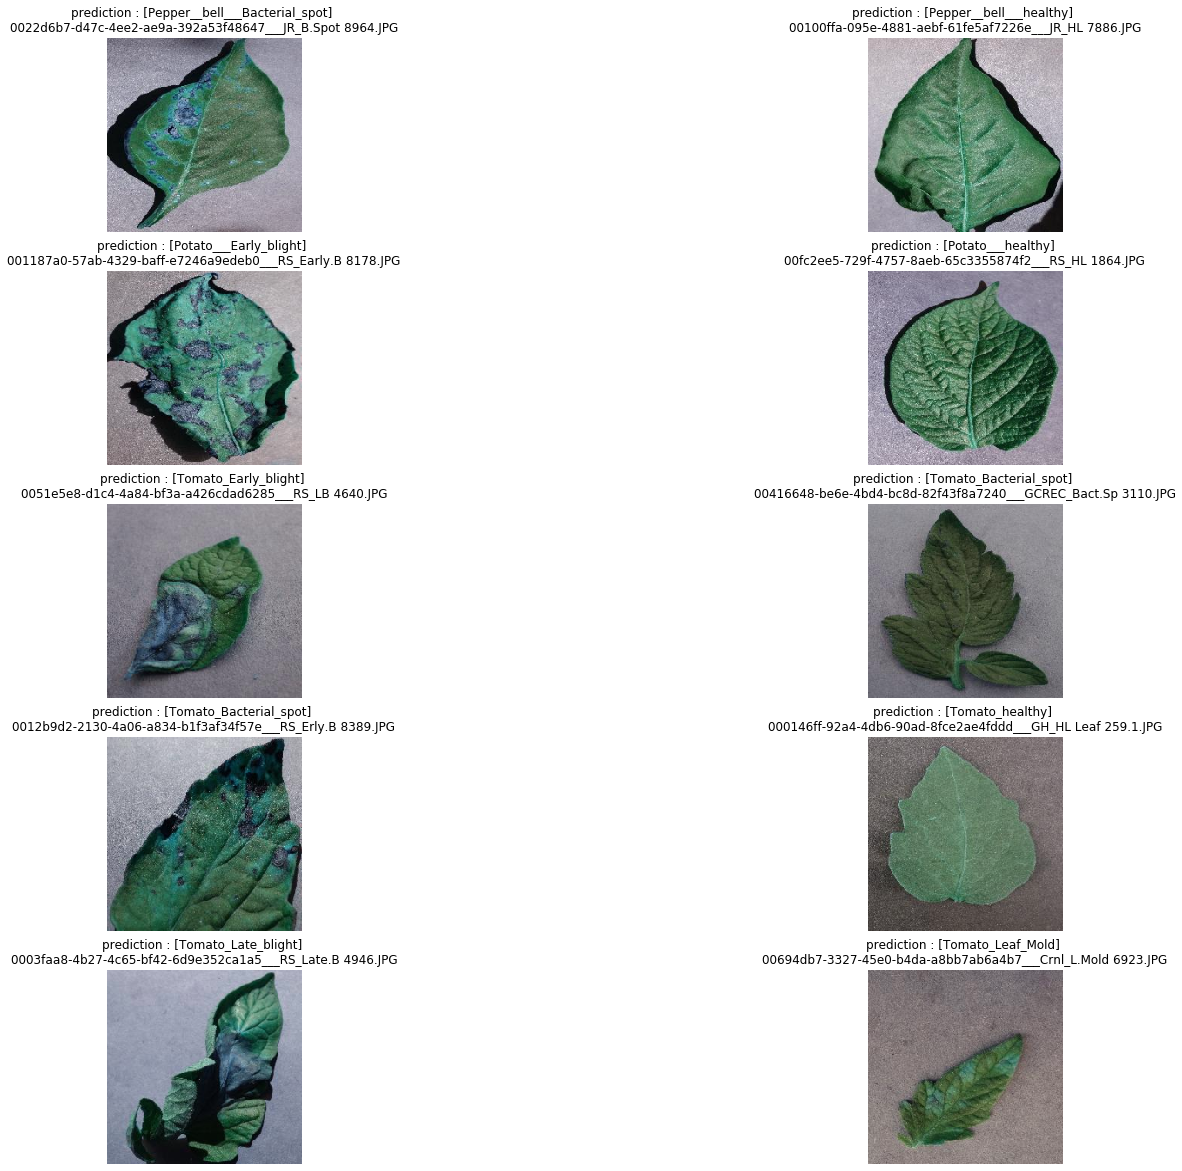

In [90]:
pred_lab = get_labels(predictions)

predfigure = plt.figure(figsize = (25,25))
def plot_image_1(fig, image, label, prediction, predictions_label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image)
    title = "prediction : [" + str(predictions_label) + "] "+ "\n" + label
    plt.title(title)
    return

image_index = 0
row =6
col = 2
for i in range(1,(row*col-1)):
    plot_image_1(predfigure, test_images[image_index], test_labels[image_index], predictions[image_index], pred_lab[image_index], row, col, i)
    image_index = image_index + 1
plt.show()

Loading the pretrained models for the transfer learning process

In [22]:
# vgg_model = VGG16(input_shape=(112,112,3), weights='imagenet', include_top=False)
# resnet_model = ResNet50(input_shape=(112,112,3), weights='imagenet', include_top=False)
incep_model=InceptionV3(input_shape=(112,112,3), weights='imagenet', include_top=False)

Setting all the weights to be non-trainable

In [72]:
for layer in incep_model.layers:
    layer.trainabla=False

Import and use the pretrained model without it's last layer. In addition to using GAP layer and Droupout layer just before the Dense layer.

In [24]:
x=incep_model.output
x=Dropout(0.5)(x)
x=GlobalAveragePooling2D()(x)
pred=Dense(n_classes,activation="softmax")(x)
tl_model=Model(input=incep_model.input, output=pred)


C:\Users\Workstation1\Anaconda3\envs\gpuenv\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """


Setting up the training parameters

In [25]:
epochs=50
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
adam=Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.999, amsgrad=False)

Compiling the model and setting the checkpointer

In [26]:
tl_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

checkpointer_2= ModelCheckpoint(filepath='D:\Mahmoud Nada\Hesham\incep_trial_1.hdf5',
                             verbose=1,save_best_only=True)
tl_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 112, 112, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 55, 55, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 55, 55, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 55, 55, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

Training the model

In [27]:
tl_model_history=tl_model.fit(X_train, y_train, 
          validation_data=(val_norm_image_list, val_image_labels),
          epochs=50, batch_size=32, callbacks=[checkpointer_2], verbose=1)


Train on 6659 samples, validate on 1500 samples
Epoch 1/50
6659/6659 [==============================] - 30s 4ms/step - loss: 0.8784 - accuracy: 0.7372 - val_loss: 2.4060 - val_accuracy: 0.5347

Epoch 00001: val_loss improved from inf to 2.40602, saving model to D:\Mahmoud Nada\Hesham\incep_trial_1.hdf5
Epoch 2/50
6659/6659 [==============================] - 19s 3ms/step - loss: 0.5073 - accuracy: 0.8405 - val_loss: 0.8055 - val_accuracy: 0.7687

Epoch 00002: val_loss improved from 2.40602 to 0.80545, saving model to D:\Mahmoud Nada\Hesham\incep_trial_1.hdf5
Epoch 3/50
6659/6659 [==============================] - 19s 3ms/step - loss: 0.3256 - accuracy: 0.9000 - val_loss: 0.2640 - val_accuracy: 0.9113

Epoch 00003: val_loss improved from 0.80545 to 0.26403, saving model to D:\Mahmoud Nada\Hesham\incep_trial_1.hdf5
Epoch 4/50
6659/6659 [==============================] - 19s 3ms/step - loss: 0.2906 - accuracy: 0.9144 - val_loss: 2.0076 - val_accuracy: 0.5553

Epoch 00004: val_loss did not

Loading the best weights obtained from the checkpointer during the training

In [28]:
tl_model.load_weights('D:\Mahmoud Nada\Hesham\incep_trial_1.hdf5')


Model evaluation by calculating the accuracy

In [29]:
score=tl_model.evaluate(X_test,y_test,verbose=1)
print("test accuracy:",score)

1665/1665 [==============================] - 1s 833us/step
test accuracy: [0.12467354455509455, 0.9657657742500305]


Plotting: the training accuracy vs the validation accuracy and the training loss vs validation loss

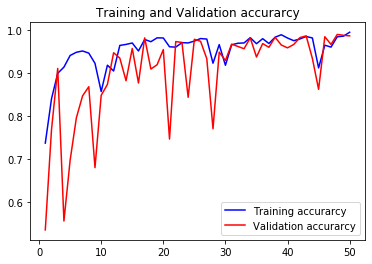

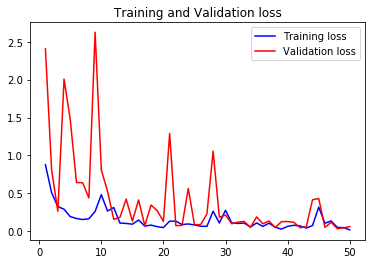

In [30]:
acc = tl_model_history.history['accuracy']
val_acc = tl_model_history.history['val_accuracy']
loss = tl_model_history.history['loss']
val_loss = tl_model_history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()


In [32]:
# tl_model.save("D:\Mahmoud Nada\Hesham\saved__tl_mode_final.h5")

In [88]:
tl_predictions=get_predictions(test_images,tl_model)

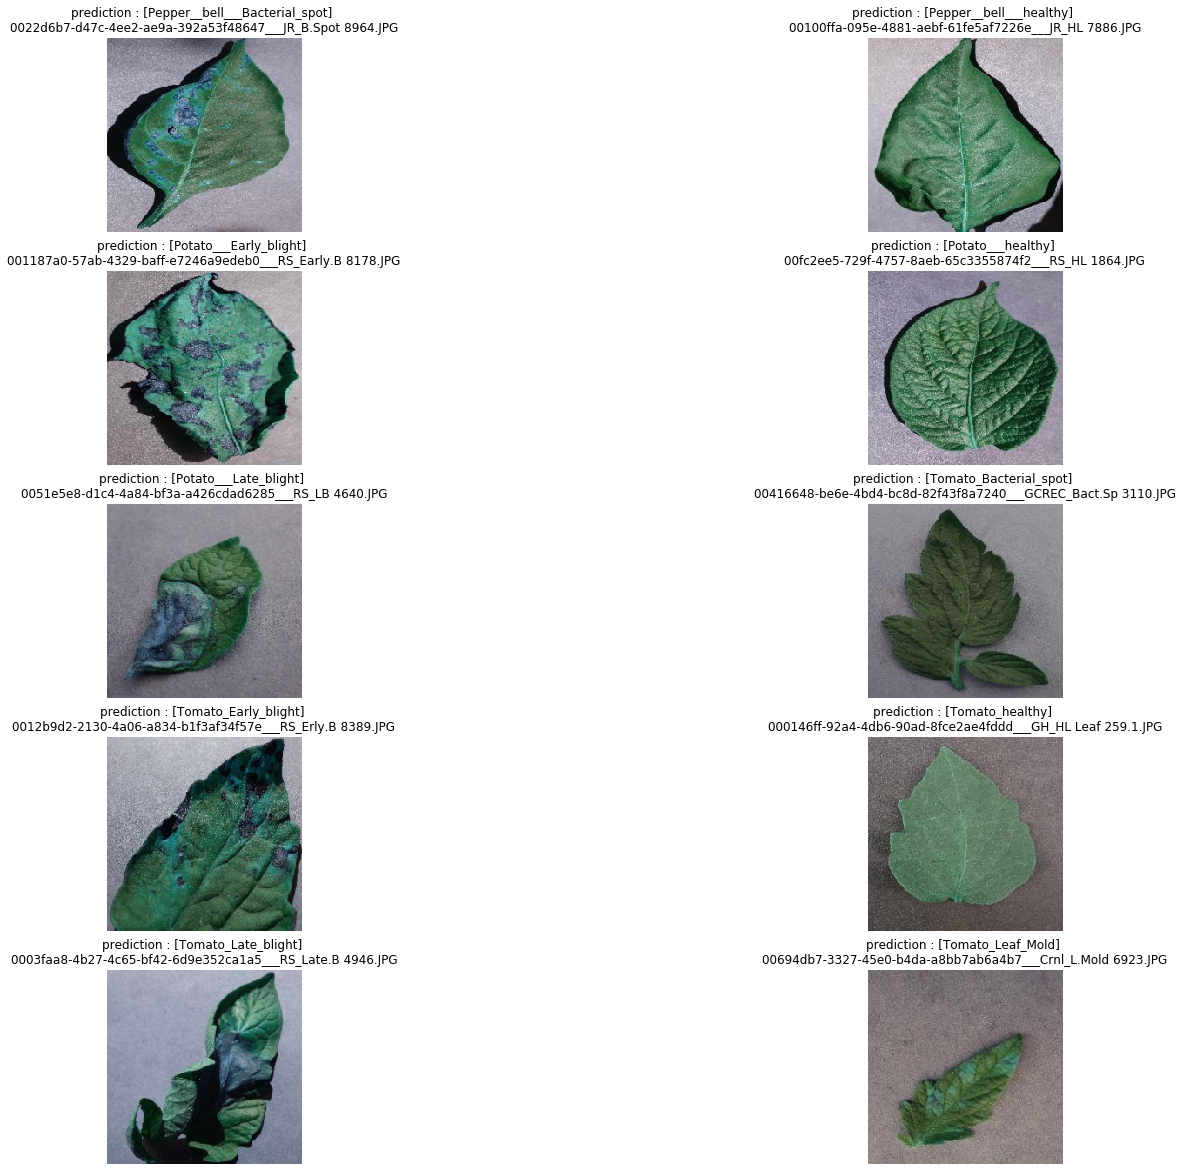

In [87]:
pred_lab = get_labels(predictions)

predfigure = plt.figure(figsize = (25,25))
def plot_image_1(fig, image, label, prediction, predictions_label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image)
    title = "prediction : [" + str(predictions_label) + "] "+ "\n" + label
    plt.title(title)
    return

image_index = 0
row =6
col = 2
for i in range(1,(row*col-1)):
    plot_image_1(predfigure, test_images[image_index], test_labels[image_index], predictions[image_index], pred_lab[image_index], row, col, i)
    image_index = image_index + 1
plt.show()